# ARIMA Predictions

## Temperature Predictions

In [12]:
# general data manipulation libraries
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
from sklearn.metrics import mean_squared_error # for model evaluation

# general data visualization libraries
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# for time series analysis
from statsmodels.tsa.stattools import adfuller # for ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for ACF and PACF plots

# for ARIMA modeling
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# import the data
path = 'raw_temperature.csv'
df_temperature = pd.read_csv(path)

df_temperature.head()

,datetime,Pittsburgh,Chicago
0,2012-10-01 12:00:00,NaN,NaN
1,2012-10-01 13:00:00,281.000000,284.010000
2,2012-10-01 14:00:00,281.024767,284.054691
3,2012-10-01 15:00:00,281.088319,284.177412
4,2012-10-01 16:00:00,281.151870,284.300133


In [3]:
# check for missing values
df_temperature.isnull().sum()

datetime      0
Pittsburgh    3
Chicago       3
dtype: int64

In [4]:
# set datetime as datetime format
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'])

# set datetime as index
df_temperature.set_index('datetime', inplace=True)

# specify the frequency of the data as hourly
df_temperature = df_temperature.asfreq('h')

Due to daylight saving time we have 2 missing values in the middle of the dataset that we proceed to fill them with the avg values in between. We remove the first row.

In [5]:
# fill missing values with average between adjacent values
df_temperature['Pittsburgh'] = df_temperature['Pittsburgh'].interpolate(method='linear')

# remove first row
df_temperature = df_temperature.drop(df_temperature.index[0])

# check again
df_temperature.isnull().sum()

Pittsburgh    0
Chicago       2
dtype: int64

In [6]:
# separate the dataset into two datasets
df_temperature_pittsburgh = df_temperature['Pittsburgh'].copy()

# transform from kelvin into celcius
df_temperature_pittsburgh = df_temperature_pittsburgh - 273.15

### ARIMA Model Order Selection

### Stationarity


- There are [three basic criterion](https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda#Time-Series-Prediction-with-ARIMA) for a time series to understand whether it is stationary series or not.
    - Statistical properties of time series such as mean, variance should remain constant over time to call time series is stationary
        - constant mean
        - constant variance
        - autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.
- Now we visualize and check seasonality.

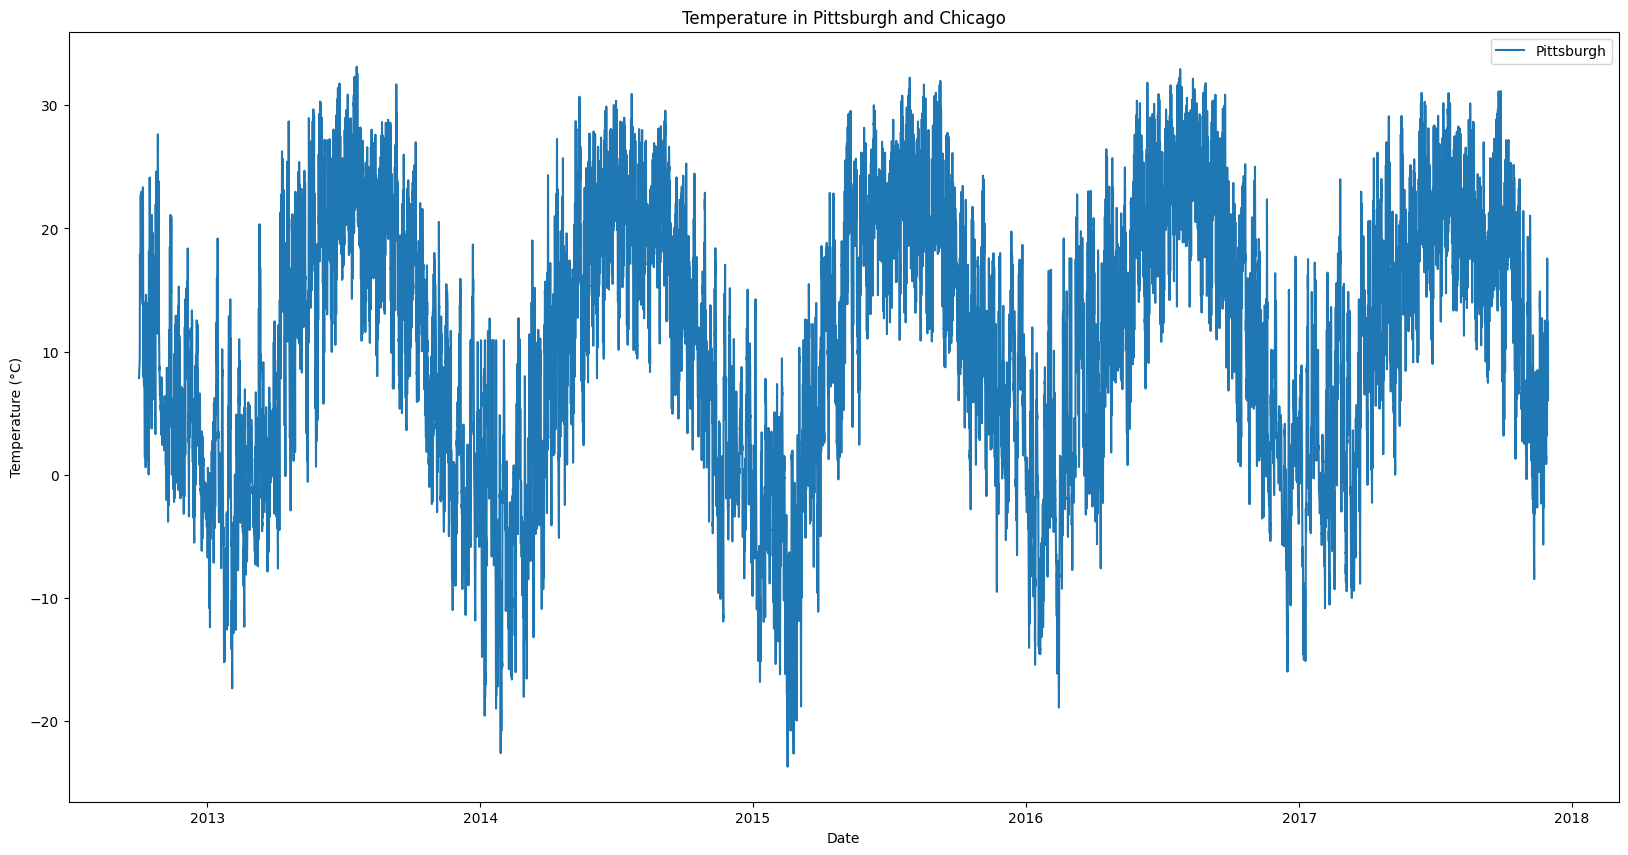

In [7]:
# create figure
plt.figure(figsize=(20, 10))

# plot the data
sns.lineplot(data=df_temperature_pittsburgh, label='Pittsburgh')

# set title and labels
plt.title('Temperature in Pittsburgh and Chicago')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

As we previously saw in the EDA notebook, our series presents an oscillatory seasonal variation.

To check the stationarity of the time series, we can (as done previously) calculate a [moving average](https://en.wikipedia.org/wiki/Moving_average) or perform an [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The test results comprise a Test Statistic and Critical Values for different confidence levels. 

If the test statistic is less than the critical value, we can conclude that the time series is stationary. This indicates that the statistical properties of the series (mean, variance, autocorrelation) remain constant over time.

In [8]:
# ADF test for Pittsburgh
adf_pittsburgh = adfuller(df_temperature_pittsburgh)
print('Pittsburgh')
print('ADF Statistic: %f' % adf_pittsburgh[0])
print('p-value: %f' % adf_pittsburgh[1])
print('Critical Values:')
for key, value in adf_pittsburgh[4].items():
    print('\t%s: %.3f' % (key, value))

Pittsburgh
ADF Statistic: -8.328956
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


The Augmented Dickey-Fuller (ADF) test statistic is more negative than all critical values at 1%, 5%, and 10% significance levels. Additionally, the p-values for both cities are 0.000000, which is less than the standard 0.05 significance level.

Interpretation:

1.    The null hypothesis of the ADF test (that the time series has a unit root and is non-stationary) is rejected for both Pittsburgh and Chicago
2.    We can conclude with high confidence that both time series are stationary.

After confirming the stationarity of our time series through the ADF test, we now need to determine the optimal order for our ARIMA model. The ARIMA order is represented by (p,d,q), where:

- p: The order of the autoregressive (AR) term
- d: The degree of differencing
- q: The order of the moving average (MA) term

Based on our ADF test results, we've established that d = 0, as our series is already stationary. To determine the optimal values for p and q, we'll examine the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. These plots will help us identify potential values for the AR and MA terms.

Let's calculate and visualize the ACF and PACF to guide our selection of p and q:

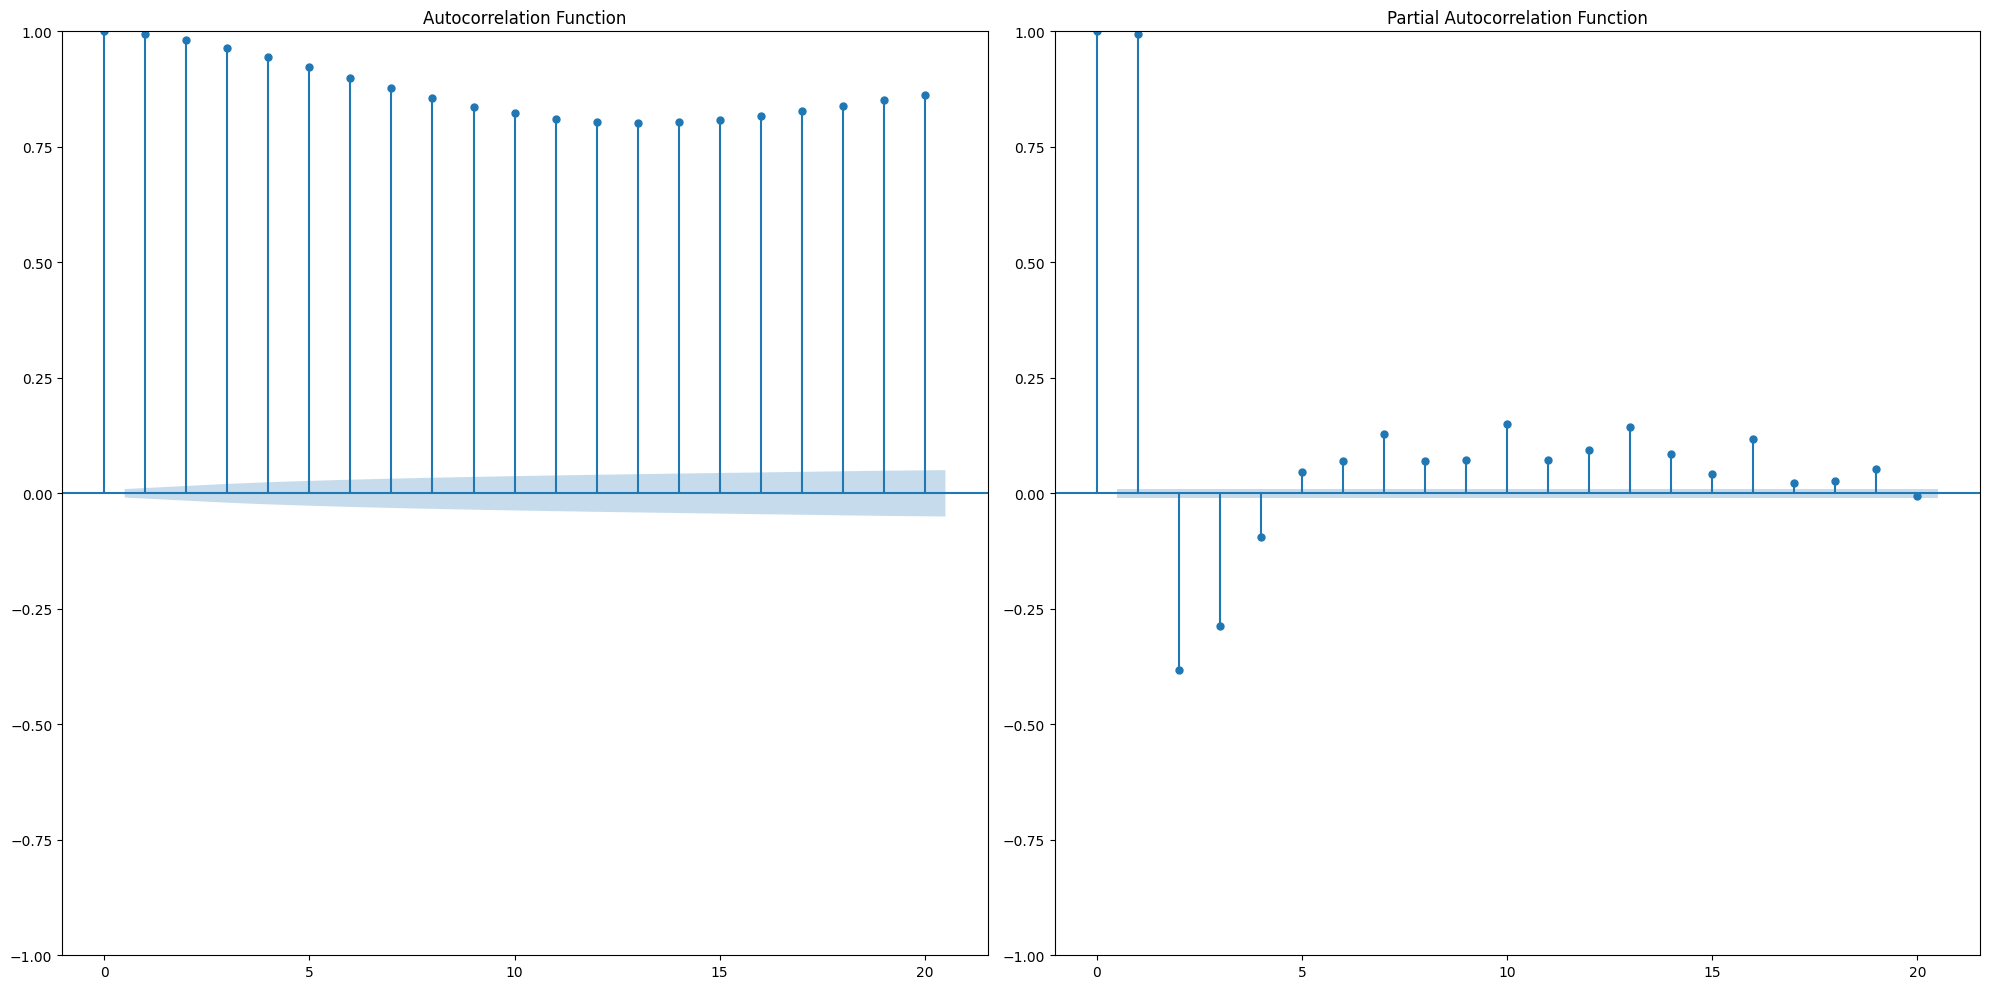

In [9]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_temperature_pittsburgh, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_temperature_pittsburgh, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

Due to the length of the dataset, the 95% CI bands are very narrow for a 24-hour lag and all the points fall outside them. **Which is good**, autocorrelations that exceed the upper or lower CI bands are considered statistically significant; lags inside the bands are considered random noise and not meaningful for model selection.

Initial tentative model order:

- p = 1 (first significant lag in PACF)
- q = 1 (significant autocorrelation pattern in ACF)
- d = 0 (already stationary series)

Model Selection Strategy

- Start with ARIMA(1,0,1)
- Compare with alternative models like ARIMA(2,0,1) or ARIMA(1,0,2)
- Use information criteria (AIC/BIC) to select the best model
- Validate model performance through residual analysis and forecasting accuracy

In [15]:
# calculate the split index
split_index = int(len(df_temperature_pittsburgh) * 0.8)

# split the dataset
train_pittsburgh = df_temperature_pittsburgh[:split_index]
test_pittsburgh = df_temperature_pittsburgh[split_index:]

# instantiate the 24h model
model_24 = ETSModel(train_pittsburgh, error='add', trend='add', seasonal='add', seasonal_periods=24)
model_24_fit = model_24.fit()

# fourier terms for yearly seasonality
fourier_yearly = Fourier(period=8760, order=5)
fourier_train = fourier_yearly.in_sample(index=train_pittsburgh.index)
fourier_test = fourier_yearly.out_of_sample(steps=len(test_pittsburgh), index=test_pittsburgh.index)

# instantiate the 24h * 365 model using SARIMAX
model_365 = SARIMAX(train_pittsburgh, order=(1, 0, 1), seasonal_order=(2, 0, 1, 24), exog=fourier_train)
model_365_fit = model_365.fit()

c:\Users\kinda\anaconda3\envs\Devs_Institute\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for the combined model: 11.66


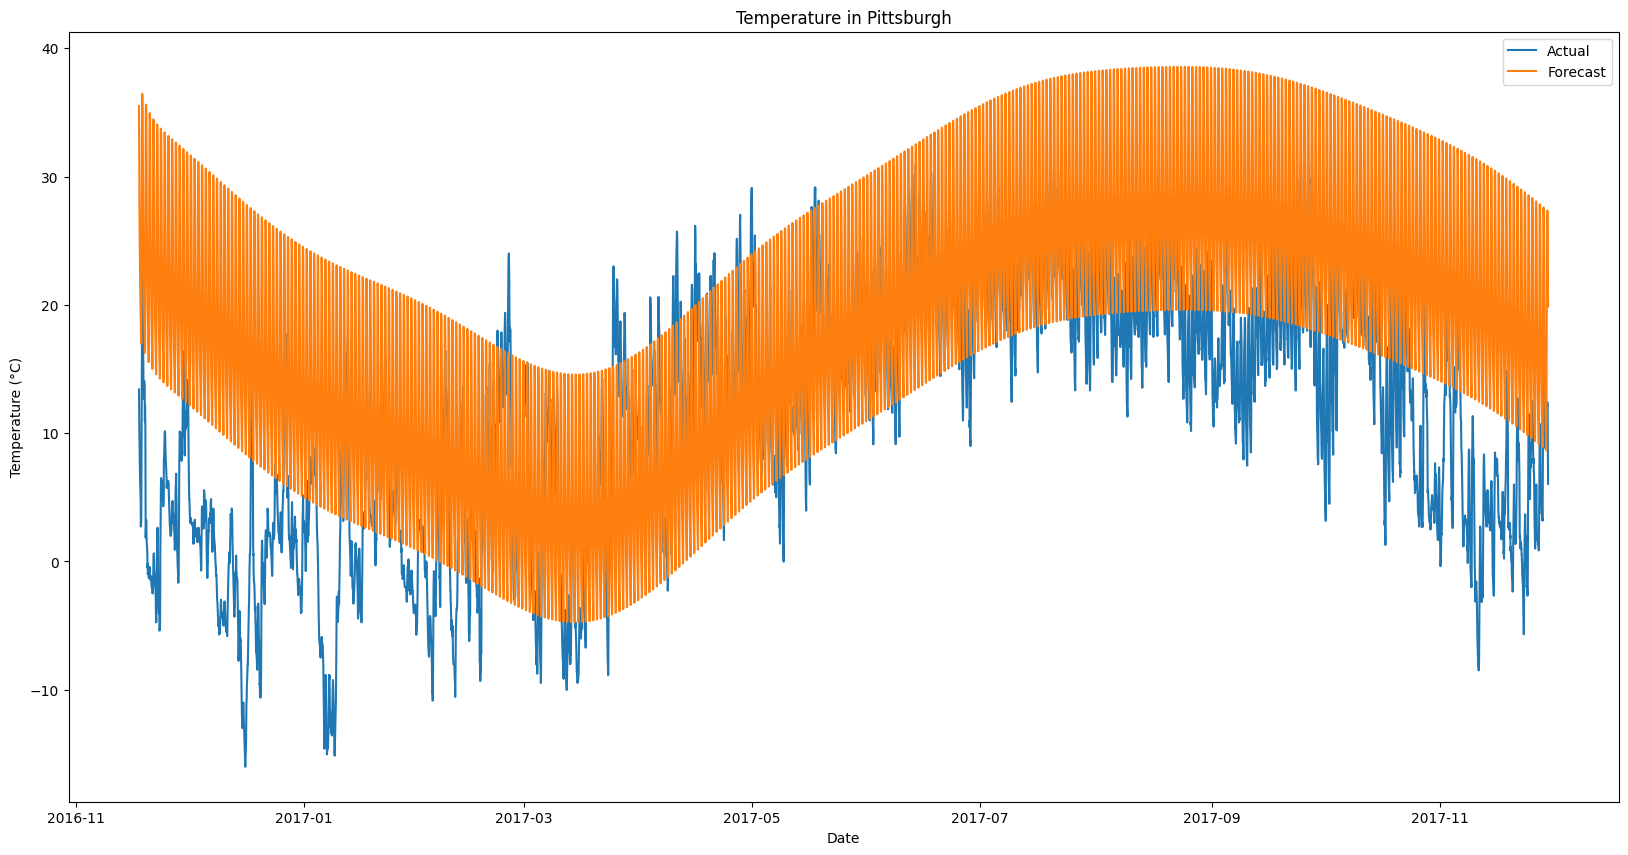

In [16]:
# forecast the test set
forecast_24 = model_24_fit.forecast(steps=len(test_pittsburgh))
forecast_365 = model_365_fit.forecast(steps=len(test_pittsburgh), exog=fourier_test)

# combine models with weights
forecast_combined = forecast_24 + forecast_365

# calculate the RMSE
rmse_combined = np.sqrt(mean_squared_error(test_pittsburgh, forecast_combined))
print('RMSE for the combined model: %.2f' % rmse_combined)

# create figure
plt.figure(figsize=(20, 10))

# plot the data
sns.lineplot(data=test_pittsburgh, label='Actual')
sns.lineplot(data=forecast_combined, label='Forecast')

# set title and labels
plt.title('Temperature in Pittsburgh')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()